In [11]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use("seaborn-v0_8-darkgrid")
import seaborn as sns
sns.set(rc={"figure.dpi":200, 'savefig.dpi':200 , 'figure.figsize': (10, 5)})
sns.set_context('notebook')
sns.set_style("ticks")
sns.set_style('darkgrid')

from pycaret.regression import *

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML

In [12]:
# ADD TIME FEATURES
def add_time_features(df, time_column):
    
    df[time_column] = pd.to_datetime(df[time_column])  # Make sure the time column is in datetime format
    
    # Extract various time features
    #df['hour'] = df[time_column].dt.hour
    df['day_of_week'] = df[time_column].dt.dayofweek
    df['month'] = df[time_column].dt.month
    df['day_of_year'] = df[time_column].dt.dayofyear
    df['week_of_year'] = df[time_column].dt.isocalendar().week 
    df['year'] = df[time_column].dt.year

    df['sin_hour'] = np.sin(2*np.pi * df[time_column].dt.hour/24.)
    df['cos_hour'] = np.cos(2*np.pi * df[time_column].dt.hour/24.)
    
    return df

In [13]:
def add_interactions(df): 
    df['sun_elev_cloud_cover_interaction'] = df['sun_elevation:d'] * df['total_cloud_cover:p']

    df['radiation_interaction'] = df['clear_sky_rad:W'] * df['diffuse_rad:W'] * df['direct_rad:W']

    df['atmospheric_interaction'] = df['air_density_2m:kgm3'] * df['msl_pressure:hPa']

    df['temp_humidity_interaction'] = df['dew_point_2m:K'] * df['t_1000hPa:K']

    df['snow_radiation_interaction'] = df['fresh_snow_1h:cm'] * df['clear_sky_rad:W']  # Replace 'clear_sky_rad:W' with 'albedo' if available

    return df

In [14]:
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

def add_polynomial_features(df, feature_list, degree=2):
    """
    Adds polynomial features for specified features in a DataFrame.

    Parameters:
    - df: pandas.DataFrame - The original DataFrame.
    - feature_list: list - A list of column names to create polynomial features for.
    - degree: int - The degree of the polynomial features to create.

    Returns:
    - df: pandas.DataFrame - The DataFrame with added polynomial features.
    """

    # Initialize the PolynomialFeatures transformer
    poly_transformer = PolynomialFeatures(degree=degree, include_bias=False)

    for feature in feature_list:
        # Check if the feature exists in the dataframe to avoid KeyError
        if feature in df.columns:
            # Reshape the feature column to a 2D array for PolynomialFeatures
            feature_data = df[[feature]].values
            
            # Create polynomial features for the selected feature
            feature_poly = poly_transformer.fit_transform(feature_data)
            
            # Generate new feature names
            feature_names = [f"{feature}^{i}" for i in range(1, degree + 1)]
            
            # Convert the output array to a DataFrame with new feature names
            feature_poly_df = pd.DataFrame(feature_poly, columns=feature_names)
            
            # Concatenate the new polynomial features to the original DataFrame
            df = pd.concat([df, feature_poly_df.iloc[:, 1:]], axis=1)  # Skip the original feature column
            
    return df

def add_rolling_average(df, window_size, fill_method='ffill'):
    """
    Adds rolling average columns to the dataframe based on the specified window size.
    Args:
    - df: The input dataframe.
    - window_size: The number of periods to consider for calculating the rolling average.
    
    Returns:
    - df with new columns for the rolling averages of selected features.
    """
    rolling_features = ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm',
       'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm',
       'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
       'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_depth:cm',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms']
    for feature in rolling_features:
        rolling_name = f'{feature}_rolling_avg_{window_size}'
        df[rolling_name] = df[feature].rolling(window=window_size, min_periods=1, center=True).mean()

        # Handle NaN values at the edges
        if fill_method == 'ffill':
            df[rolling_name].fillna(method='ffill', inplace=True)
        elif fill_method == 'bfill':
            df[rolling_name].fillna(method='bfill', inplace=True)
    return df

In [15]:

def plot_targets(targets, start_date, end_date):
    # Slice the dataframe based on the provided start and end dates
    targets_subset = targets[(targets['time'] >= start_date) & (targets['time'] <= end_date)]

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.plot(targets_subset['time'], targets_subset['pv_measurement'], label='PV Measurement', color='blue')
    plt.xlabel('Time')
    plt.ylabel('PV Measurement')
    plt.title('PV Measurement Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [16]:
def make_categorical(df, feature_list):
    for feature in feature_list:
        df[feature] = df[feature].astype('category')
    return df

In [17]:
def add_time_delta(observed, estimated, test):
    estimated['time_delta'] = (estimated['date_forecast'] - estimated['date_forecast'].dt.normalize()).dt.total_seconds() / 3600
    observed['time_delta'] = 0
    test['time_delta'] = (test['date_forecast'] - test['date_forecast'].dt.normalize()).dt.total_seconds() / 3600
    return observed, estimated, test

def add_is_estimated(observed, estimated, test):
    estimated['is_estimated'] = 1
    observed['is_estimated'] = 0
    test['is_estimated'] = 1
    return observed, estimated, test

def process_data(observed, estimated, test):
    observed, estimated, test = add_time_delta(observed, estimated, test)
    observed, estimated, test = add_is_estimated(observed, estimated, test)
    train = pd.concat([observed, estimated], axis=0).sort_values(by='date_forecast')
    return train, test

def set_date_time(targets, observed, estimated, test):
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])
    return targets, observed, estimated, test

def resample_data(observed, estimated, test):
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    return observed_resampled, estimated_resampled, test_resampled

def extract_is_day_feature(test):
    is_day_feature = test[['date_forecast', 'is_day:idx']]
    is_day_feature['is_day:idx'] = is_day_feature['is_day:idx'].replace({0.25: 1, 0.5: 1, 0.75: 1, 1: 1, 0: 0})
    return is_day_feature

def extract_time_limit(targets):
    first_date = targets['time'].min()
    last_date = targets['time'].max()
    return first_date, last_date

def drop_features(train, test):
    train = train.drop(columns=['time', 'date_forecast', 'pv_measurement'])
    test = test.drop(columns=['date_forecast'])
    return train, test

def add_several_rolling_average(train, test, lst_of_window_sizes):
    for size in lst_of_window_sizes: 
        train = add_rolling_average(train, window_size=size)
        test = add_rolling_average(test, window_size=size)
    return train, test

In [18]:
def calculate_incidence_angles(df, latitude = 60):
    # Define a function to calculate the angle of incidence for a given row
    def angle_of_incidence(row, tilt_angle_rad, panel_azimuth_rad):
        sun_elevation_rad = np.radians(row['sun_elevation:d'])
        sun_azimuth_rad = np.radians(row['sun_azimuth:d'])
        cos_theta = (
            np.sin(sun_elevation_rad) * np.sin(tilt_angle_rad) +
            np.cos(sun_elevation_rad) * np.cos(tilt_angle_rad) * np.cos(sun_azimuth_rad - panel_azimuth_rad)
        )
        cos_theta = np.clip(cos_theta, -1, 1)  # Ensure cos_theta is within valid range
        return np.degrees(np.arccos(cos_theta))
    
    # Calculate the tilt angle and panel azimuth assuming Norway is in the northern hemisphere
    tilt_angle_rad = np.radians(latitude)
    panel_azimuth_rad = 0  # True south

    # Apply the angle_of_incidence function to each row
    df['angle_of_incidence'] = df.apply(angle_of_incidence, axis=1, tilt_angle_rad=tilt_angle_rad, panel_azimuth_rad=panel_azimuth_rad)
    
    return df

In [19]:
def add_wind_features(train, test):
    for df in [train, test]:
        # Horizontal wind speed magnitude at 10 meters
        df['wind_speed_10m_vector_magnitude:ms'] = np.sqrt(df['wind_speed_u_10m:ms']**2 + df['wind_speed_v_10m:ms']**2)

        # Wind direction at 10 meters
        df['wind_direction_10m:degrees'] = np.degrees(np.arctan2(df['wind_speed_v_10m:ms'], df['wind_speed_u_10m:ms']))

        # Temperature-adjusted wind speed at 10 meters
        df['temp_adjusted_wind_speed_10m:ms'] = df['wind_speed_10m:ms'] * (df['t_1000hPa:K'] / 273.15)

        # Vertical wind shear between surface and 1000 hPa
        # Note: this requires careful interpretation as mentioned earlier
        df['wind_shear_1000hPa_10m:ms'] = df['wind_speed_w_1000hPa:ms'] - df['wind_speed_10m:ms']

        # Wind energy density at 10 meters
        df['wind_energy_density_10m:Wm2'] = 0.5 * 1.225 * (df['wind_speed_10m:ms']**3)  # Using 1.225 kg/m3 as air density at sea level

    return train, test

In [20]:
def remove_constant_blocks(df):
    '''
    Remove constant blocks from the dataframe, i.e. where the value in pv_measurement is constant
    Ex: 0,0,1 -> 0,1
    '''
    df['diff'] = df['pv_measurement'].diff().fillna(0)
    df['constant'] = (df['diff'] == 0).astype(int)
    df['block'] = (df['constant'].diff() != 0).astype(int).cumsum()
    df['block_size'] = df.groupby('block')['constant'].transform('sum') # This gets the size per block

    # Keep the first occurrence by ensuring the block size is greater than 1 and that it's a constant value.
    df = df[~((df['block_size'] >= 1) & (df['pv_measurement'] != 0))]

    # Drop the helper columns
    df.drop(['diff', 'constant', 'block', 'block_size'], axis=1, inplace=True)
    
    return df

# def remove_nonzero_constant_blocks(df, column='pv_measurement'):
#     '''
#     Remove constant blocks from the dataframe where the value in the specified column is constant and non-zero.
#     Ex: 0,0,1,1,1 -> 0,0
#         2,2,0,0,1 -> 0,0,1
#     '''
#     # Calculate the difference between consecutive rows and identify constant blocks
#     df['diff'] = df[column].diff().fillna(0)
#     df['constant'] = (df['diff'] == 0).astype(int)
#     df['block'] = (df['constant'].diff() != 0).astype(int).cumsum()
    
#     # Determine the value of each block and its size
#     df['block_value'] = df.groupby('block')[column].transform('first') # The value of the block
#     df['block_size'] = df.groupby('block')['constant'].transform('sum') # This gets the size per block
    
#     # We only want to keep the block if its size is 1 (non-constant) or if the constant value is 0
#     # This is done by checking if the block size is 1 or if the block value is 0.
#     df = df[(df['block_size'] == 1) | (df['block_value'] == 0)]
    
#     # Drop the helper columns
#     df.drop(['diff', 'constant', 'block', 'block_value', 'block_size'], axis=1, inplace=True)
    
#     return df

In [21]:
def preprocessing(targets, observed, estimated, test):
    targets, observed, estimated, test = set_date_time(targets, observed, estimated, test)
    
    observed, estimated, test = resample_data(observed, estimated, test)

    is_day_feature = extract_is_day_feature(test)

    first_date, last_date = extract_time_limit(targets)
    start_date, end_date = '2017-07-01', '2024-08-30'  
   
    
    train, test = process_data(observed, estimated, test)

    train, test = add_several_rolling_average(train, test, lst_of_window_sizes = [3, 5, 7])

    merged_data = pd.merge(targets, train, how='inner', left_on='time', right_on='date_forecast')

    # Remove constant blocks from the data
    train = remove_constant_blocks(merged_data)

    ###### This one should be double checked ########
    # Remove rows where pv_measurement is 0
    train = train[merged_data['pv_measurement'] != 0]

    # Add the time-based features
    train = add_time_features(train, 'time')  
    test = add_time_features(test, 'date_forecast') 

    targets = train[['time', 'pv_measurement']]
    
    plot_targets(targets, start_date, end_date)

    train, test = drop_features(train, test)

    # train = calculate_incidence_angles(train)
    # test = calculate_incidence_angles(test)

    # train, test = add_wind_features(train, test)

    return train, test, is_day_feature, targets

In [22]:
from pycaret.regression import *
def process_location_catboost(exp_reg):
    
    catboost = exp_reg.create_model('catboost')
    #catboost = exp_reg.tune_model(catboost)
    #catboost = exp_reg.ensemble_model(catboost, method='Bagging')

    return catboost

def process_location_lightgbm(exp_reg):

    lightgbm = exp_reg.create_model('lightgbm')
    #lightgbm = exp_reg.tune_model(lightgbm)
    #lightgbm = exp_reg.ensemble_model(lightgbm, method='Bagging')

    return lightgbm

def process_location_extratrees(exp_reg):
    
    extratrees = exp_reg.create_model('et')
    #extratrees = exp_reg.tune_model(extratrees)
    #extratrees = exp_reg.ensemble_model(extratrees, method='Bagging')
    
    return extratrees

def process_location_randomforest(exp_reg):

    randomforest = exp_reg.create_model('rf')
    #randomforest = exp_reg.tune_model(randomforest)
    #randomforest = exp_reg.ensemble_model(randomforest, method='Bagging')

    return randomforest

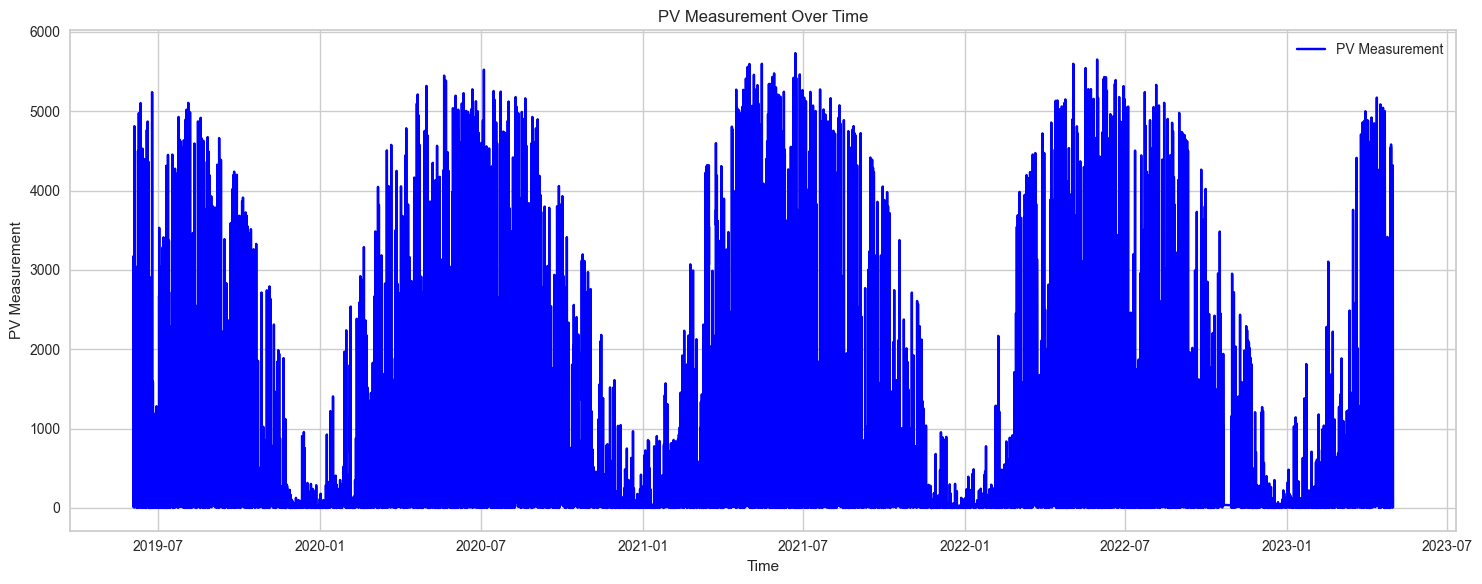

18036 X
18036 y
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training bec

           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     328.0997  258620.0636  508.5470  0.8612  0.8701  3.8416
1     307.6419  247458.7662  497.4523  0.8628  0.8202  2.4618
2     316.9570  273731.7934  523.1938  0.8486  0.8841  3.2988
3     313.4311  257044.9217  506.9960  0.8574  0.8175  2.3818
4     336.2025  283502.7634  532.4498  0.8484  0.8393  2.5163
5     334.5425  292344.0766  540.6885  0.8477  0.8468  2.5024
6     311.7983  256326.0000  506.2865  0.8626  0.8731  3.0497
7     327.5536  282413.0210  531.4255  0.8625  0.7988  2.2063
8     323.4882  273116.1751  522.6052  0.8522  0.8621  2.5457
9     337.6204  312728.3868  559.2212  0.8395  0.8681  2.3975
Mean  323.7335  273728.5968  522.8866  0.8543  0.8480  2.7202
Std    10.2583   18810.6765   17.8389  0.0077  0.0269  0.4868
#############################################
LGBM Done


           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     332.3571  270150.0811  519.7596  0.8550  0.7590  2.0064
1     319.2038  278816.4284  528.0307  0.8454  0.6999  1.2669
2     325.6797  290617.3695  539.0894  0.8393  0.7223  1.3384
3     328.7218  288743.1410  537.3482  0.8398  0.7146  1.2509
4     341.2394  301080.9481  548.7084  0.8390  0.7437  1.4425
5     344.2038  313484.9882  559.8973  0.8366  0.6964  1.0905
6     323.7821  287342.9194  536.0438  0.8459  0.7360  1.7940
7     348.4004  322449.2842  567.8462  0.8430  0.6993  1.3479
8     337.9892  303750.5547  551.1357  0.8356  0.7234  1.2621
9     345.7280  326914.1440  571.7641  0.8322  0.7463  1.7159
Mean  334.7305  298334.9859  545.9623  0.8412  0.7241  1.4516
Std     9.6702   17642.0307   16.1278  0.0061  0.0207  0.2755
#############################################
Random Forest Done


           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     325.1207  256313.5133  506.2741  0.8624  0.7870  2.5728
1     307.0020  255845.6819  505.8119  0.8581  0.7449  1.7568
2     315.0511  274395.0095  523.8273  0.8482  0.7920  2.1349
3     315.7026  264087.1462  513.8941  0.8535  0.7647  1.6852
4     332.8728  283813.7656  532.7417  0.8482  0.7844  1.8863
5     334.7050  294651.2830  542.8179  0.8464  0.7677  1.7634
6     311.7377  263236.0559  513.0654  0.8589  0.7955  2.3496
7     331.6524  293398.7521  541.6630  0.8571  0.7402  1.6984
8     325.3354  280001.0536  529.1513  0.8484  0.7793  1.7793
9     336.3797  311493.3349  558.1159  0.8401  0.7981  1.9652
Mean  323.5559  277723.5596  526.7363  0.8521  0.7754  1.9592
Std     9.9721   17489.6689   16.5070  0.0066  0.0194  0.2863
#############################################
Blended
#############################################
Finalized
float64
date_forecast 

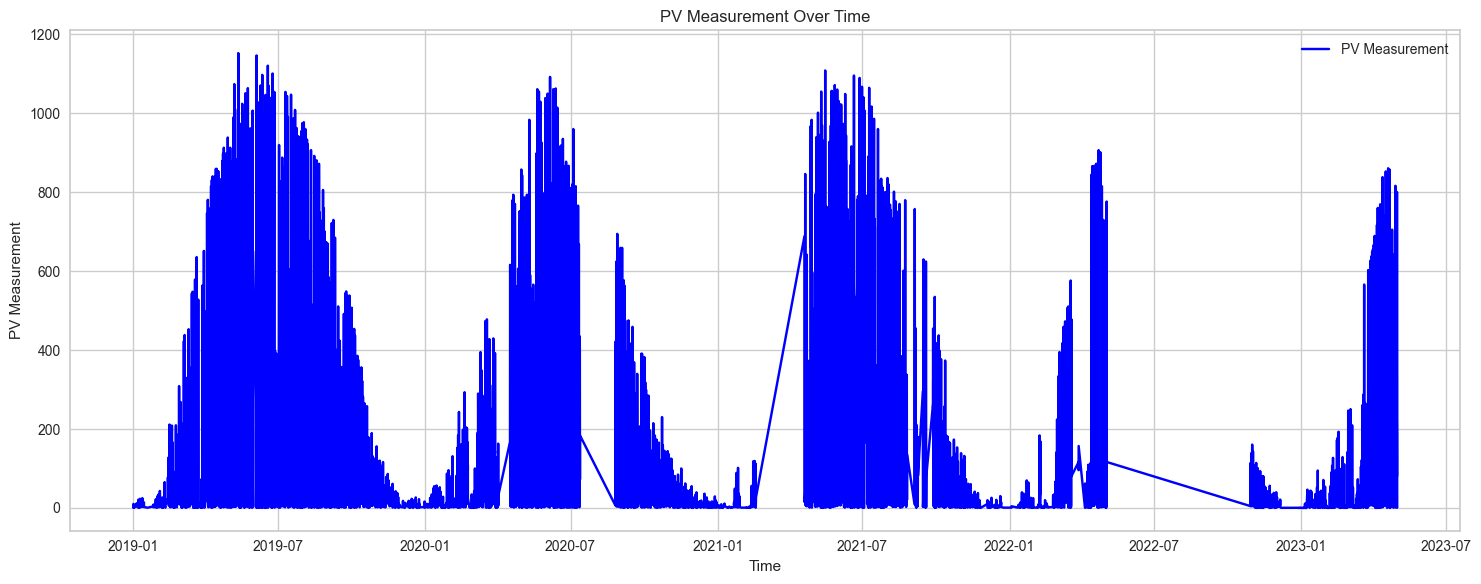

12274 X
12274 y
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training bec

          MAE        MSE     RMSE      R2   RMSLE     MAPE
Fold                                                      
0     51.6640  7217.8177  84.9577  0.8991  0.7102   1.6347
1     51.1409  7325.2274  85.5875  0.8937  0.6864   1.4001
2     50.8894  7277.7934  85.3100  0.8894  0.6789   1.4741
3     48.0088  6169.8648  78.5485  0.9071  0.6934   1.2443
4     49.2459  6282.4499  79.2619  0.9091  0.6929   1.5877
5     49.4979  6647.6428  81.5331  0.8982  0.7357   1.7762
6     52.1738  7349.3408  85.7283  0.8936  0.7496   1.6273
7     49.3383  6531.7346  80.8191  0.9071  0.7377   1.8188
8     56.8915  9510.5084  97.5218  0.8739  0.6970  49.0323
9     53.4294  8176.2121  90.4224  0.8705  0.6987   1.3799
Mean  51.2280  7248.8592  84.9690  0.8942  0.7081   6.2975
Std    2.4287   946.9253   5.3964  0.0126  0.0231  14.2459
#############################################
LGBM Done


          MAE         MSE      RMSE      R2   RMSLE     MAPE
Fold                                                        
0     54.3685   7826.6036   88.4681  0.8906  0.7045   1.8613
1     53.6734   8408.7369   91.6992  0.8780  0.6518   1.3615
2     53.5427   7855.8177   88.6331  0.8807  0.6669   1.5878
3     51.2341   6690.4349   81.7951  0.8993  0.7092   1.4823
4     53.2404   7351.3847   85.7402  0.8936  0.6804   1.5167
5     52.9958   7562.1088   86.9604  0.8842  0.7093   1.6150
6     53.0424   7424.2900   86.1643  0.8925  0.6992   1.4158
7     51.8309   7310.2261   85.4999  0.8960  0.7270   1.8130
8     60.0171  10462.5881  102.2868  0.8613  0.7002  10.7425
9     54.7934   8738.7282   93.4812  0.8616  0.6857   1.2632
Mean  53.8739   7963.0919   89.0728  0.8838  0.6934   2.4659
Std    2.2800    997.4467    5.3968  0.0129  0.0212   2.7645
#############################################
Random Forest Done


          MAE        MSE     RMSE      R2   RMSLE     MAPE
Fold                                                      
0     52.2786  7299.1829  85.4353  0.8980  0.7010   1.7310
1     51.3067  7581.9954  87.0747  0.8900  0.6535   1.3605
2     51.2661  7324.1081  85.5810  0.8887  0.6554   1.4183
3     48.7994  6207.1572  78.7855  0.9065  0.6844   1.3466
4     50.2969  6586.7046  81.1585  0.9047  0.6758   1.5294
5     50.3834  6898.6244  83.0580  0.8944  0.7151   1.6778
6     51.6461  7141.3105  84.5063  0.8966  0.7026   1.4711
7     49.7581  6686.1151  81.7687  0.9049  0.7213   1.7791
8     57.4724  9720.9486  98.5949  0.8711  0.6895  29.8594
9     53.1693  8251.0770  90.8354  0.8693  0.6834   1.2919
Mean  51.6377  7369.7224  85.6798  0.8924  0.6882   4.3465
Std    2.2805   952.0119   5.3565  0.0125  0.0216   8.5058
#############################################
Blended
#############################################
Finalized
float64
date_forecast    datetime64[ns]
is_day:idx              

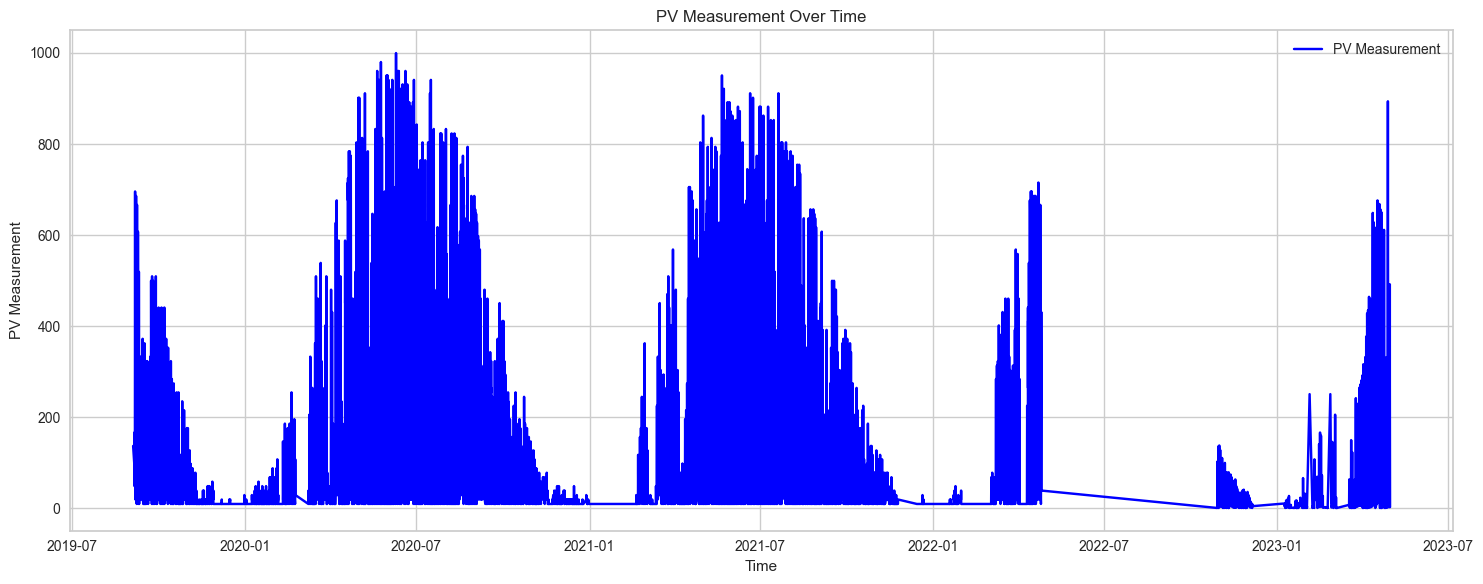

9676 X
9676 y
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training becau

          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     44.0741  5364.9199  73.2456  0.8820  0.5491  0.6594
1     43.1470  5022.9768  70.8730  0.8992  0.5280  0.5676
2     42.7419  5117.5442  71.5370  0.8966  0.4720  0.5090
3     49.5533  6045.1360  77.7505  0.8569  0.5790  0.7420
4     43.2046  4833.2488  69.5216  0.9050  0.5157  0.6498
5     44.2841  4971.4967  70.5088  0.8944  0.4923  0.5763
6     45.9466  5635.8662  75.0724  0.8665  0.4843  0.5398
7     44.5766  5250.7138  72.4618  0.8756  0.6137  0.9677
8     44.3210  5000.9102  70.7171  0.8940  0.5392  0.6761
9     47.4205  5755.6768  75.8662  0.8813  0.4995  0.5626
Mean  44.9270  5299.8489  72.7554  0.8851  0.5273  0.6450
Std    2.0298   375.1768   2.5497  0.0147  0.0422  0.1272
#############################################
LGBM Done


          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     48.0404  6375.2811  79.8454  0.8598  0.5619  0.7497
1     46.0191  5764.3524  75.9233  0.8843  0.5423  0.6469
2     45.4989  5472.7103  73.9778  0.8894  0.4768  0.5527
3     52.2158  6826.2935  82.6214  0.8384  0.5963  0.8355
4     45.6190  5266.1249  72.5681  0.8965  0.5168  0.6859
5     47.3236  5678.1353  75.3534  0.8794  0.5180  0.6764
6     48.3808  6141.3713  78.3669  0.8545  0.4946  0.5432
7     48.2843  6183.8762  78.6376  0.8535  0.6556  1.3156
8     45.7373  5490.6710  74.0991  0.8836  0.5468  0.7866
9     50.1940  6282.8292  79.2643  0.8705  0.5239  0.6089
Mean  47.7313  5948.1645  77.0657  0.8710  0.5433  0.7401
Std    2.0861   465.3672   3.0065  0.0178  0.0493  0.2120
#############################################
Random Forest Done


          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     45.1552  5673.6940  75.3239  0.8752  0.5424  0.6949
1     43.8236  5216.9710  72.2286  0.8953  0.5186  0.5939
2     43.1576  5125.0477  71.5894  0.8964  0.4609  0.5199
3     50.1059  6225.0032  78.8987  0.8526  0.5753  0.7732
4     43.7300  4884.3629  69.8882  0.9040  0.5098  0.6545
5     44.8380  5115.6330  71.5237  0.8914  0.4981  0.6153
6     46.4525  5716.0682  75.6047  0.8646  0.4814  0.5315
7     45.5934  5485.7096  74.0656  0.8700  0.6260  1.1344
8     44.3890  5058.4037  71.1225  0.8927  0.5300  0.7205
9     47.8472  5835.8839  76.3930  0.8797  0.5016  0.5691
Mean  45.5092  5433.6777  73.6638  0.8822  0.5244  0.6807
Std    2.0214   401.7424   2.7054  0.0156  0.0454  0.1701
#############################################
Blended
#############################################
Finalized
float64
date_forecast    datetime64[ns]
is_day:idx              float32
dtype:

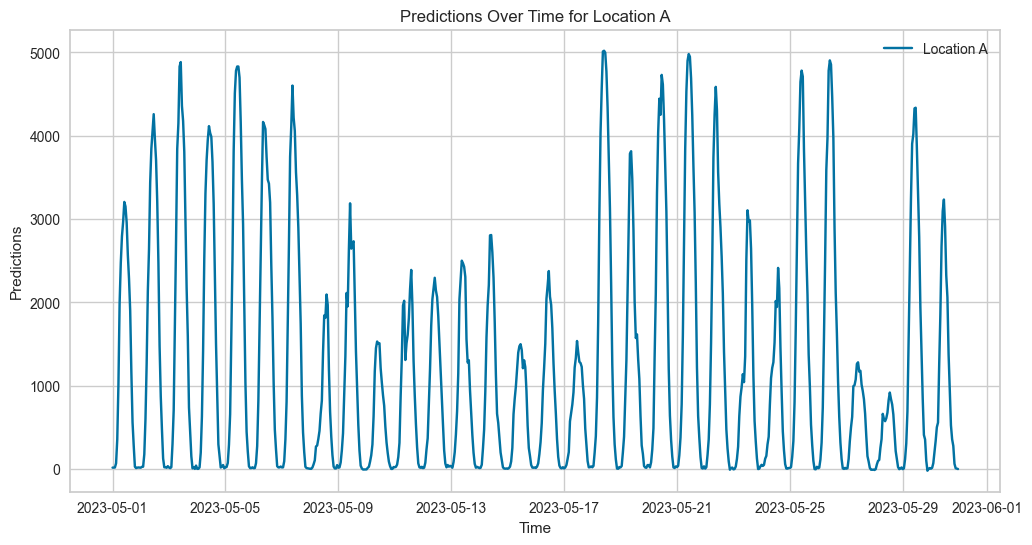

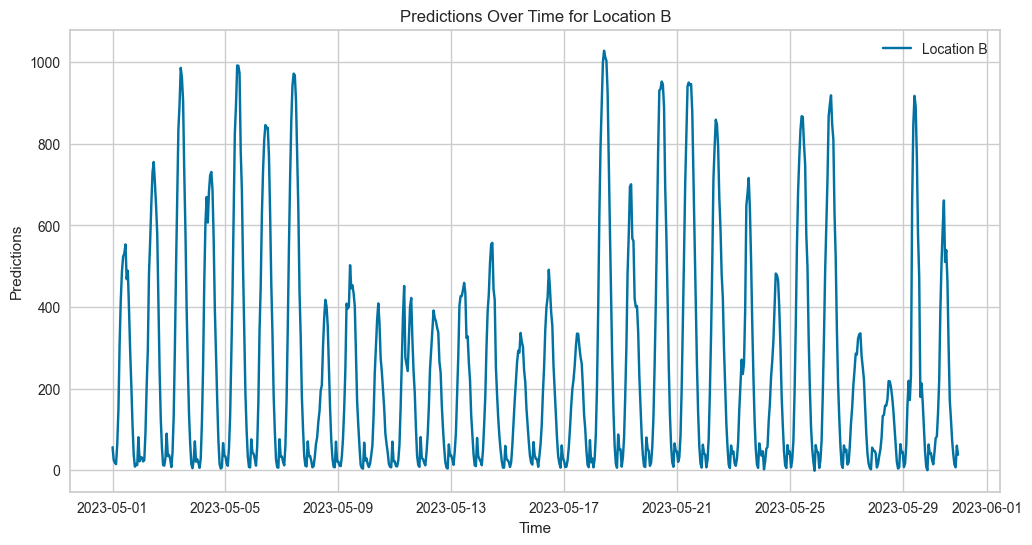

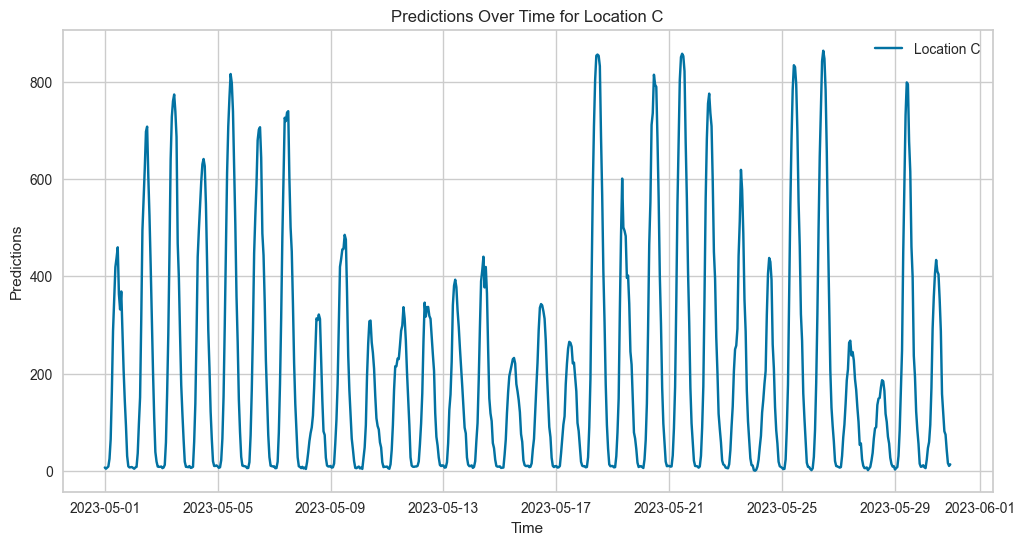

In [85]:
from pycaret.regression import *

locations = ['A', 'B', 'C']
all_predictions = []
final_df_list = [] 


for loc in locations:
    # Load your data
    train = pd.read_parquet(f'Data/{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'Data/{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'Data/{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'Data/{loc}/X_test_estimated.parquet')

    #lage dag og måned feature der man aggregerer opp 
    # Preprocess data
    X_train, X_test, is_day_feature, targets = preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)
    y_train = targets
    if X_train.empty or len(y_train) == 0:
        print(f"X_train or y_train is empty for location {loc}")

    # Ensure X and y have the same length
    print(len(X_train), 'X')
    print(len(y_train),'y')
    min_length = min(len(X_train), len(y_train))
    X_train, y_train = X_train.iloc[:min_length], y_train[:min_length]


    data = X_train.copy()
    data.columns = data.columns.str.replace('[^\w\s]', '')

    X_test.columns = X_test.columns.str.replace('[^\w\s]', '')


    data['target'] = y_train['pv_measurement']

    exp_reg = RegressionExperiment()
    exp_reg.setup(data=data, 
                target='target', 
                session_id=123,
                categorical_features=['dew_or_rimeidx', 'is_in_shadowidx', 'is_estimated'],
                html=False,
                experiment_name=f'exp_{loc}', 
                use_gpu=True,
                verbose=False)
    
    # Process the location data and get the final model
    # model_catboost = process_location_catboost(exp_reg)
    # print("#############################################")
    # print("Catboost Done")
    
    model_lightgbm = process_location_lightgbm(exp_reg)
    print("#############################################")
    print("LGBM Done")
    
    # model_extra_trees = process_location_extratrees(exp_reg)
    # print("#############################################")
    # print("Extra Trees Done")
    
    model_random_forest = process_location_randomforest(exp_reg)
    print("#############################################")
    print("Random Forest Done")
    # model_xtra_trees = process_location_xtra_trees(X_train, y_train, loc)

    #blend_models = blend_models(estimator_list=[model_catboost, model_lightgbm, model_xtra_trees], method='soft')
    blended_models = exp_reg.blend_models([model_lightgbm, model_random_forest])
    print("#############################################")
    print("Blended")
    # Finalize the model
    #blended_models = exp_reg.tune_model(blended_models)
    blended_models = exp_reg.finalize_model(blended_models)
    print("#############################################")
    print("Finalized")
    # Predict on new data
    predictions = exp_reg.predict_model(blended_models, data=X_test)
        #print(predictions.columns)
        # Assuming 'predictions' is the output from predict_model
    final_predictions = predictions['prediction_label']
    print(final_predictions.dtypes)
    print(is_day_feature.dtypes)
    # Multiply final predictions with the 'is_day:idx' values
    
    adjusted_final_predictions = final_predictions * is_day_feature['is_day:idx']
    adjusted_final_predictions = np.clip(adjusted_final_predictions, 0, None)
    # Now, 'adjusted_final_predictions' contains the adjusted target values.

        # Store predictions
    all_predictions.append(adjusted_final_predictions)  

        # Prepare dataframe for visualization
    num_predictions = len(predictions)
    timestamps = pd.date_range(start='2023-05-01 00:00:00', periods=num_predictions, freq='H')

    df = pd.DataFrame({
            'time': timestamps,
            'prediction': predictions['prediction_label'],
            'location': loc
        })

    final_df_list.append(df)


# Concatenate all the individual data frames and prepare for plotting
final_df = pd.concat(final_df_list, ignore_index=True)
final_df['time'] = pd.to_datetime(final_df['time'])
final_df.sort_values('time', inplace=True)

# Visualization
for loc in locations:
    # Filter data for each location
    temp_df = final_df[final_df['location'] == loc]
    
    plt.figure(figsize=(12, 6))  # Create a new figure for each location
    plt.plot(temp_df['time'], temp_df['prediction'], label=f'Location {loc}')
    plt.xlabel('Time')
    plt.ylabel('Predictions')
    plt.title(f'Predictions Over Time for Location {loc}')
    plt.legend()
    plt.show()

# If you need to save the final dataframe without 'time' and 'location' columns, you can do so before plotting
final_df_save = final_df.copy()
final_df_save = final_df_save.drop(columns=['time', 'location'])

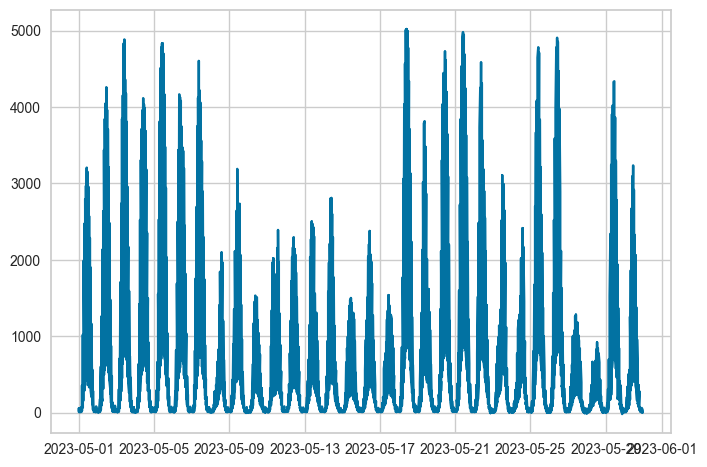

In [86]:
plt.plot(final_df['time'], final_df['prediction'], label='Prediction')

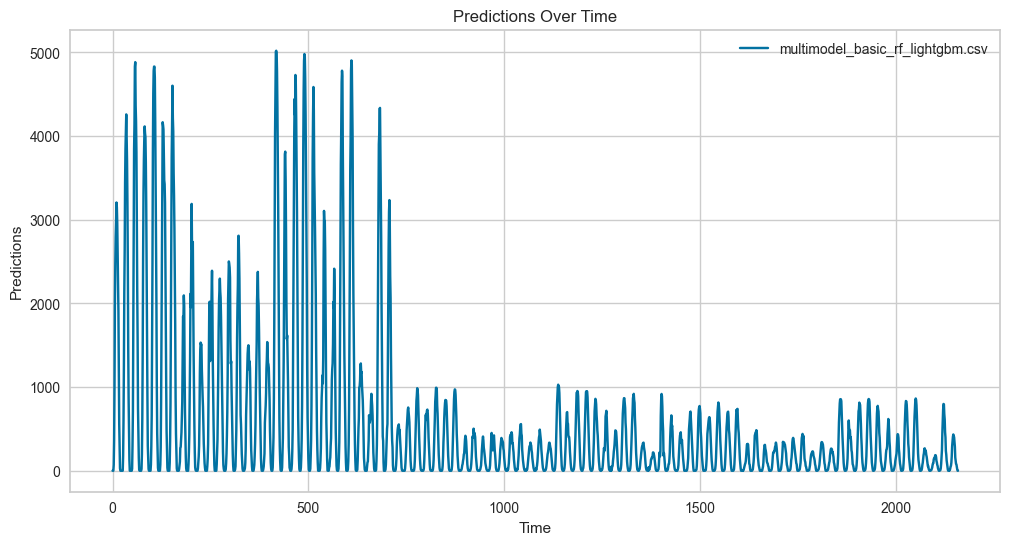

In [87]:
def save_predictions(all_predictions, title):
    final_predictions = np.concatenate(all_predictions)
    df = pd.DataFrame(final_predictions, columns=['prediction'])
    df['id'] = df.index
    df = df[['id', 'prediction']]
    df.to_csv(title, index=False)

def plot_from_csv(title):
    plt.figure(figsize=(12, 6))
    df = pd.read_csv(title)
    plt.plot(df['prediction'], label=title)
    plt.xlabel('Time')
    plt.ylabel('Predictions')
    plt.title('Predictions Over Time')
    plt.legend()
    plt.show()
    

title = 'multimodel_basic_rf_lightgbm.csv'
save_predictions(all_predictions, title)
plot_from_csv(title)

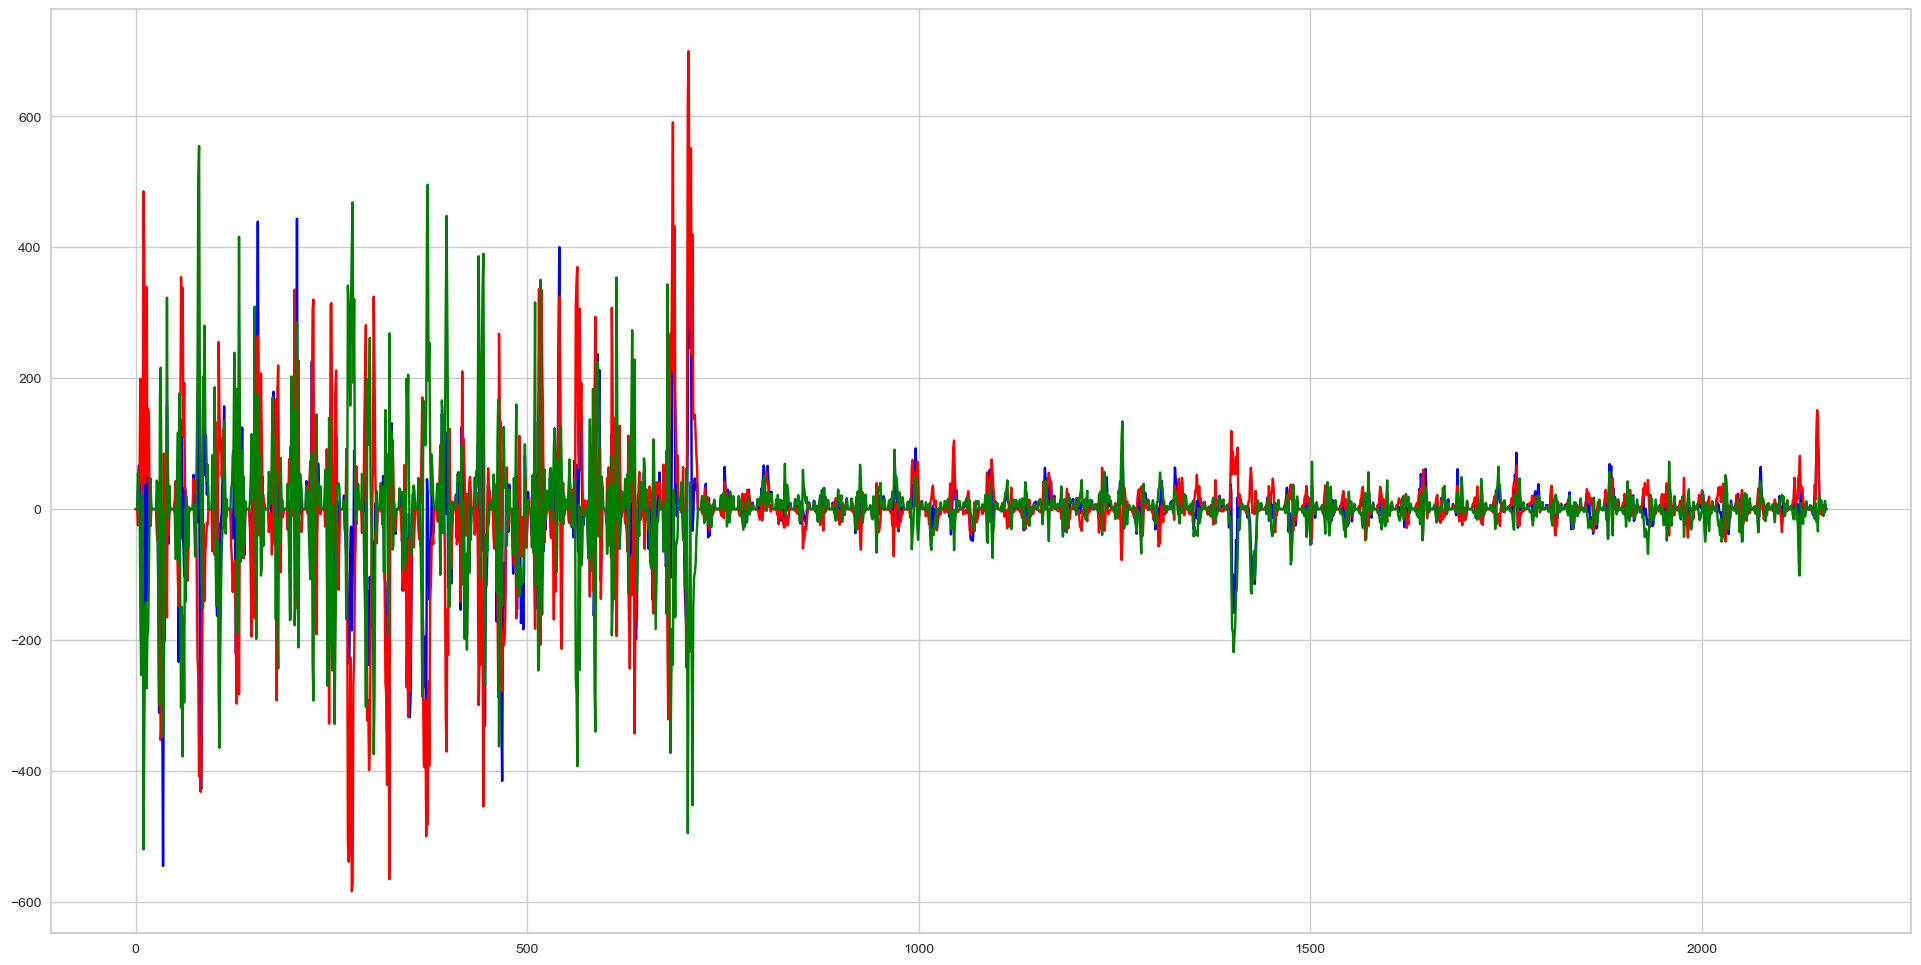

In [21]:
df1 = pd.read_csv('pycaret_catboost_IMPORTANT.csv')
df2 = pd.read_csv('pycaret_advanced_rolling357.csv')
df3 = pd.read_csv('multimodel_basic_cat_lgbm.csv')

df1['prediction'] = df1['prediction'].astype(float)
df2['prediction'] = df2['prediction'].astype(float)
df3['prediction'] = df3['prediction'].astype(float)

# Plot different between df1 and df3 
plt.figure(figsize=(24, 12))
plt.plot(df1['prediction'] - df3['prediction'], label='df1 - df3', c = 'blue')
plt.plot(df2['prediction'] - df3['prediction'], label='df2 - df3', c = 'red')   
plt.plot(df1['prediction'] - df2['prediction'], label='df1 - df2', c = 'green')
plt.show()

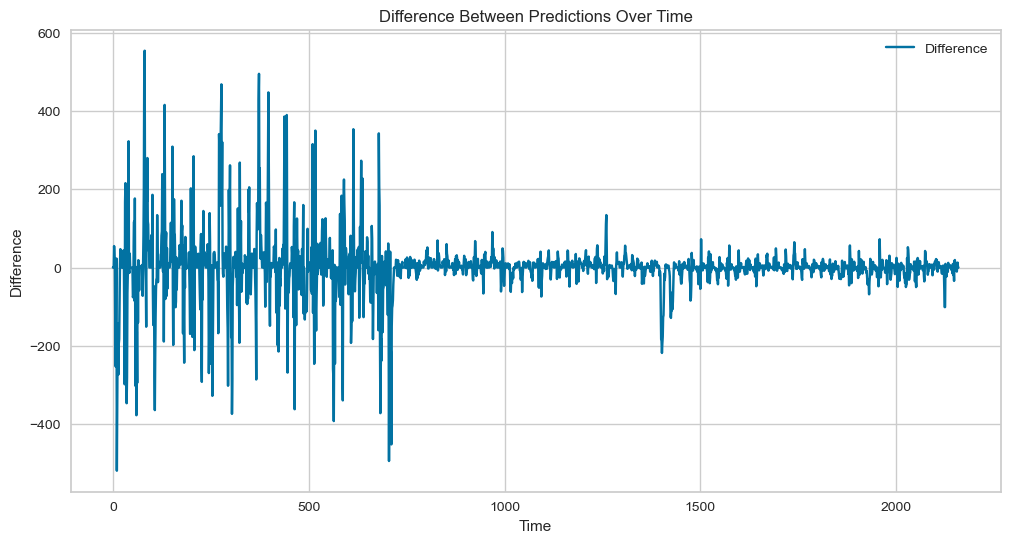

In [22]:
# read from pycaret_catboost_IMPORTANT.csv and pycaret_gbm_include_zero.csv and plot the difference
df1 = pd.read_csv('pycaret_catboost_IMPORTANT.csv')
df2 = pd.read_csv('pycaret_advanced_rolling357.csv')
df1['prediction'] = df1['prediction'].astype(float)
df2['prediction'] = df2['prediction'].astype(float)

df_diff = df1['prediction'] - df2['prediction']

plt.figure(figsize=(12, 6))
plt.plot(df_diff, label='Difference')
plt.xlabel('Time')
plt.ylabel('Difference')
plt.title('Difference Between Predictions Over Time')
plt.legend()
plt.show()


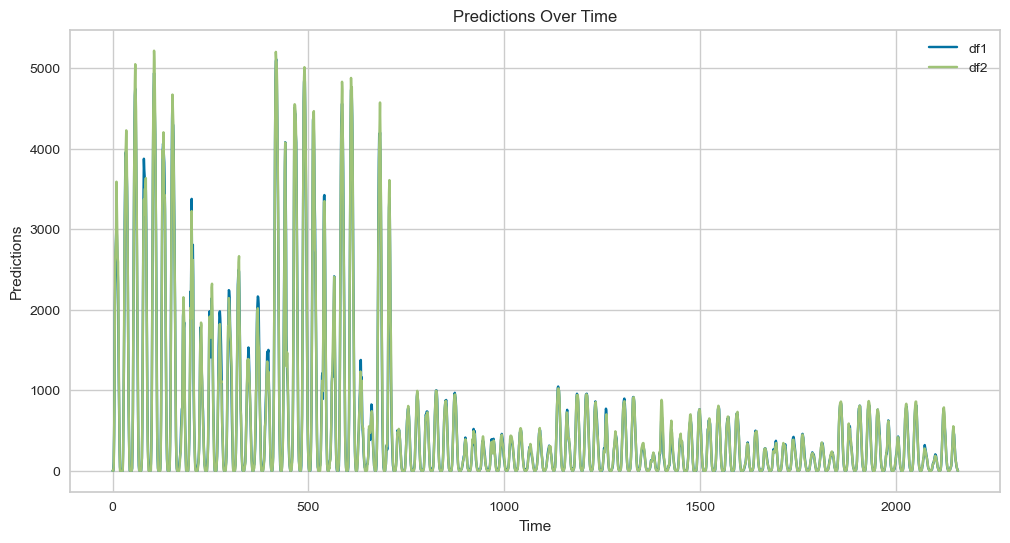

In [23]:
# plot df1 and df2
plt.figure(figsize=(12, 6))
plt.plot(df1['prediction'], label='df1')
plt.plot(df2['prediction'], label='df2')
plt.xlabel('Time')
plt.ylabel('Predictions')
plt.title('Predictions Over Time')
plt.legend()
plt.show()

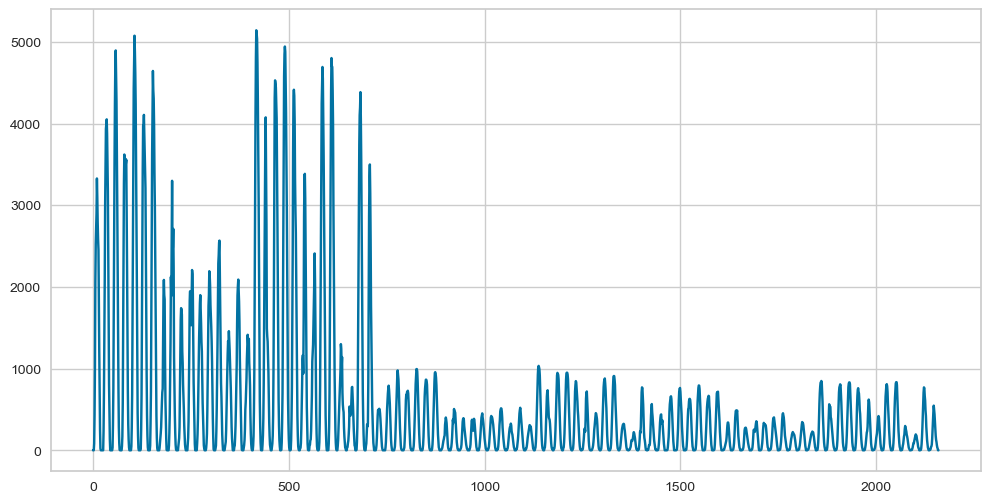

In [24]:
df1 = pd.read_csv('pycaret_catboost_IMPORTANT.csv')
df2 = pd.read_csv('pycaret_advanced_rolling357.csv')
df1['prediction'] = df1['prediction'].astype(float)
df2['prediction'] = df2['prediction'].astype(float)

# take the average of the two predictions
df_avg = (df1['prediction'] + df2['prediction']) / 2

plt.figure(figsize=(12, 6))
plt.plot(df_avg, label='Average')
plt.show()

In [25]:
# save the average predictions
df = pd.DataFrame(df_avg, columns=['prediction'])
df['id'] = df.index
df = df[['id', 'prediction']]
df.to_csv('pycaret_catboost_gbm_average.csv', index=False)

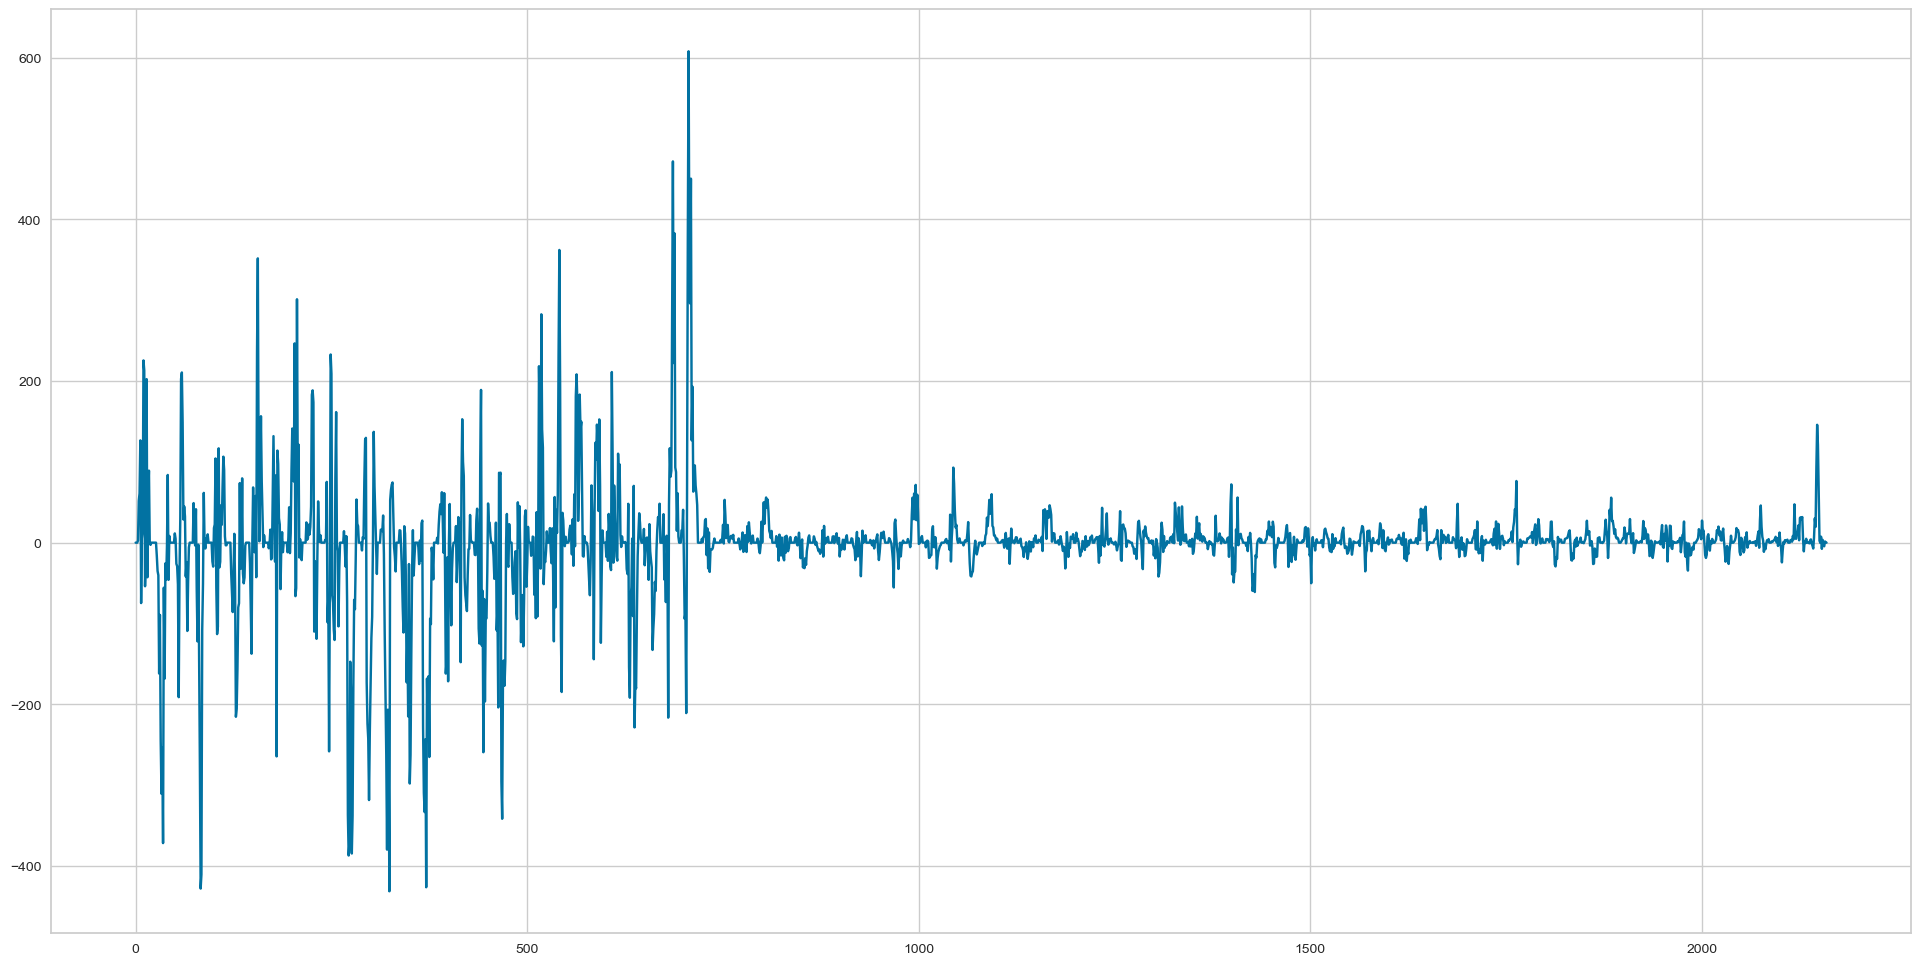

28.917852323688262


In [27]:
df_av = pd.read_csv('pycaret_catboost_gbm_average.csv')

# plot difference between df_av and df3
plt.figure(figsize=(24, 12))
plt.plot(df_av['prediction'] - df3['prediction'], label='df_av - df3')
plt.show()

#calculate MAE of df_av and df3
from sklearn.metrics import mean_absolute_error
score = mean_absolute_error(df_av['prediction'], df3['prediction'])
print(score)